In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np

import librosa as lr
from librosa.display import specshow

import matplotlib.pyplot as plt

from glob import glob

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import cv2

In [0]:
## load few data
path_file_1 = '/content/drive/My Drive/free-spoken-digit-dataset/recordings/0_jackson_0.wav'
path_file_2 = '/content/drive/My Drive/free-spoken-digit-dataset/recordings/0_yweweler_47.wav'
path_file_3 = '/content/drive/My Drive/free-spoken-digit-dataset/recordings/1_theo_31.wav'

signal_1, rate = lr.load(path_file_1)
signal_2, _ = lr.load(path_file_2)
signal_3, _ = lr.load(path_file_3)

In [0]:
## get the spectrogram
fbank_1 = lr.feature.melspectrogram(y=signal_1, sr=rate)
fbank_2 = lr.feature.melspectrogram(y=signal_2, sr=rate)
fbank_3 = lr.feature.melspectrogram(y=signal_3, sr=rate)

In [5]:
print(fbank_1.shape)
print(fbank_2.shape)
print(fbank_3.shape)

(128, 28)
(128, 15)
(128, 33)


In [0]:
## display a filterbank
def disp_fbank(fbank, rate):
  '''
  Disp a filterbank
  '''
  S = lr.amplitude_to_db(fbank, ref=np.max)

  ## display
  plt.figure(figsize=(10, 4))
  specshow(S, sr=rate, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel-frequency spectrogram')
  plt.tight_layout()
  plt.show()

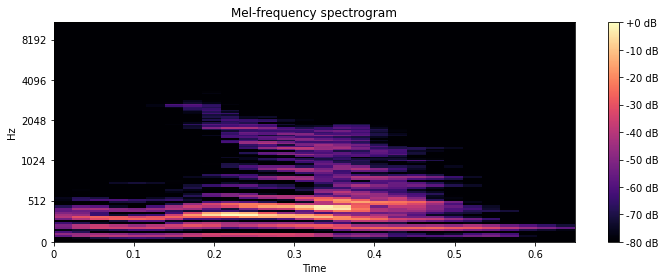

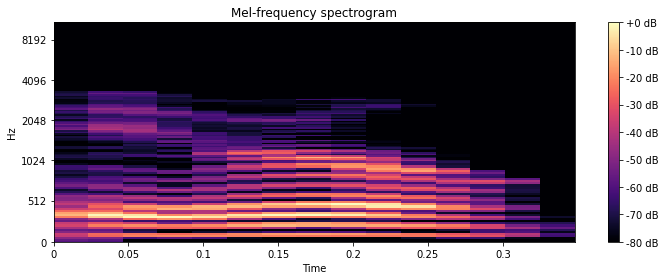

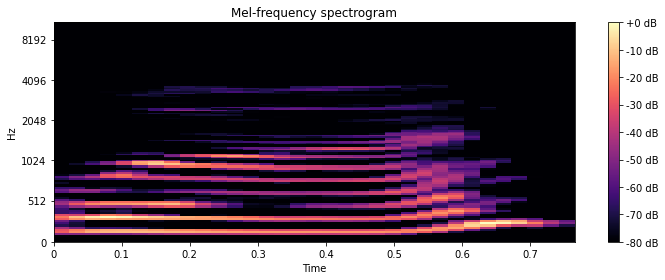

In [7]:
## display fbanks, as we can see -> different length signal
disp_fbank(fbank_1, rate)
disp_fbank(fbank_2, rate)
disp_fbank(fbank_3, rate)

In [0]:
## resize image to have same size images
## 128 * mean(size)
m = 26
dim = (m, fbank_1.shape[0])
fbank_1 = cv2.resize(fbank_1, dim, interpolation=cv2.INTER_AREA)
fbank_2 = cv2.resize(fbank_2, dim, interpolation=cv2.INTER_AREA)
fbank_3 = cv2.resize(fbank_3, dim, interpolation=cv2.INTER_AREA)

In [9]:
print(fbank_1.shape)
print(fbank_2.shape)
print(fbank_3.shape)

(128, 26)
(128, 26)
(128, 26)


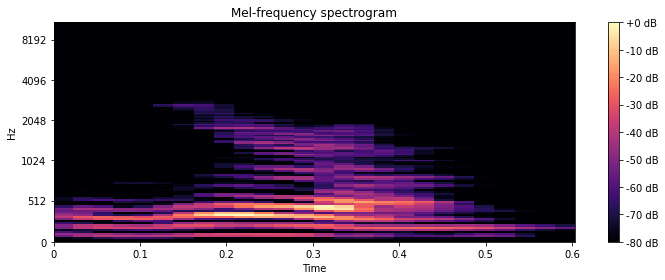

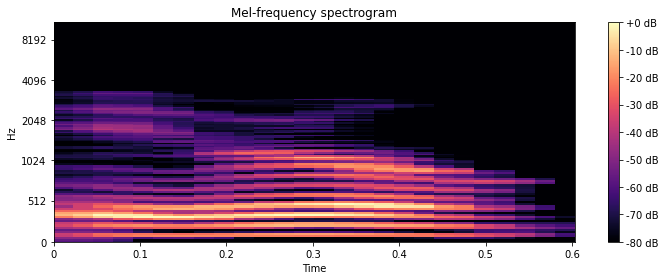

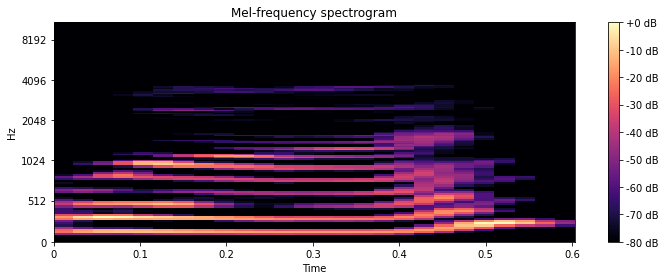

In [10]:
## display rescaled fbanks
disp_fbank(fbank_1, rate)
disp_fbank(fbank_2, rate)
disp_fbank(fbank_3, rate)

In [0]:
def load_data_spectrum(path, m=26):
  '''
  Load data from file
  Extract filter banks
  return: X_train, y_train, X_test, y_test, rate
  '''
  files = glob(path)
  speakers = ['jackson', 'nicolas', 'theo', 'yweweler']
  X, y = np.zeros((2000, 128, m)), np.zeros(2000)

  for idx, file_path in enumerate(files):
    ## load signal
    signal, rate = lr.load(file_path)

    ## extract fbanks
    fbank = lr.feature.melspectrogram(y=signal, sr=rate)

    ## rescale fbanks
    fbank = cv2.resize(fbank, (m, 128), interpolation=cv2.INTER_AREA)

    ## get label
    file_name = file_path.split('/')[-1] ## get the file name
    speaker_name = file_name.split('_')[1] ## get the speaker name
    label = speakers.index(speaker_name) ## get the label 

    if idx % 100 == 0:
      print("Filter Banks data nb {} extracted".format(idx))
    ## update X and y
    X[idx] = fbank
    y[idx] = label
1
  ## split in training and testing set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

  return X_train, y_train, X_test, y_test

In [12]:
path = '/content/drive/My Drive/free-spoken-digit-dataset/recordings/*.wav'
X_train, y_train, X_test, y_test = load_data_spectrum(path)

Filter Banks data nb 0 extracted
Filter Banks data nb 100 extracted
Filter Banks data nb 200 extracted
Filter Banks data nb 300 extracted
Filter Banks data nb 400 extracted
Filter Banks data nb 500 extracted
Filter Banks data nb 600 extracted
Filter Banks data nb 700 extracted
Filter Banks data nb 800 extracted
Filter Banks data nb 900 extracted
Filter Banks data nb 1000 extracted
Filter Banks data nb 1100 extracted
Filter Banks data nb 1200 extracted
Filter Banks data nb 1300 extracted
Filter Banks data nb 1400 extracted
Filter Banks data nb 1500 extracted
Filter Banks data nb 1600 extracted
Filter Banks data nb 1700 extracted
Filter Banks data nb 1800 extracted
Filter Banks data nb 1900 extracted


In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [18]:
print(X_train.shape)
print(X_test.shape)

(1600, 128, 26, 1)
(400, 128, 26, 1)


In [0]:
## Create our model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 26, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(158, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(4, activation='softmax'))

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 126, 24, 32)       320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 5, 64)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 3, 128)        73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 1, 128)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1792)             

In [0]:
## compile the model
adm = Adam(lr=0.01)
model.compile(optimizer=adm, loss='sparse_categorical_crossentropy', metrics=['acc'])

In [39]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
50/50 [==============================] - 7s 147ms/step - loss: 0.8709 - acc: 0.6506 - val_loss: 1.1708 - val_acc: 0.5550
Epoch 2/50
50/50 [==============================] - 7s 146ms/step - loss: 0.5242 - acc: 0.8019 - val_loss: 0.8556 - val_acc: 0.7350
Epoch 3/50
50/50 [==============================] - 7s 146ms/step - loss: 0.4754 - acc: 0.8188 - val_loss: 0.6480 - val_acc: 0.7575
Epoch 4/50
50/50 [==============================] - 7s 145ms/step - loss: 0.4819 - acc: 0.8219 - val_loss: 0.7381 - val_acc: 0.8100
Epoch 5/50
50/50 [==============================] - 7s 146ms/step - loss: 0.4241 - acc: 0.8400 - val_loss: 0.9276 - val_acc: 0.7625
Epoch 6/50
50/50 [==============================] - 7s 146ms/step - loss: 0.3647 - acc: 0.8675 - val_loss: 0.4847 - val_acc: 0.8650
Epoch 7/50
50/50 [==============================] - 7s 146ms/step - loss: 0.2706 - acc: 0.9038 - val_loss: 1.2614 - val_acc: 0.8300
Epoch 8/50
50/50 [==============================] - 7s 145ms/step - loss: 0.

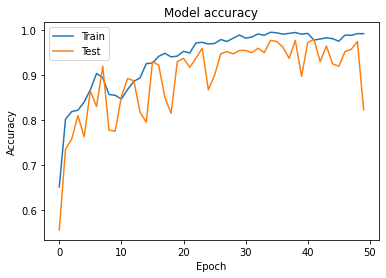

In [40]:
# plot training

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

As we can see, the testing accuracy is not constant

In [0]:
def predict(model, X_test, y_test, speakers):
  '''
  Make prediction
  '''
  for i in range(y_test.shape[0]):
    tmp = X_test[i]
    pred = model.predict(np.reshape(tmp, (1, tmp.shape[0], tmp.shape[1], 1)))
    p = np.argmax(pred)
    print("Pred: '{}'    Expected: '{}'".format(speakers[p], speakers[p]))

In [41]:
model.evaluate(X_test, y_test, verbose=2)

13/13 - 0s - loss: 0.6434 - acc: 0.8225


[0.643356442451477, 0.8224999904632568]

In [44]:
## make some prediction
speakers = ['jackson', 'nicolas', 'theo', 'yweweler']
predict(model, X_test[:20], y_test[:20], speakers)

Pred: 'nicolas'    Expected: 'nicolas'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'theo'    Expected: 'theo'
Pred: 'jackson'    Expected: 'jackson'
Pred: 'theo'    Expected: 'theo'
Pred: 'jackson'    Expected: 'jackson'
Pred: 'nicolas'    Expected: 'nicolas'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'jackson'    Expected: 'jackson'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'nicolas'    Expected: 'nicolas'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'theo'    Expected: 'theo'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'yweweler'    Expected: 'yweweler'
Pred: 'jackson'    Expected: 'jackson'
Pred: 'nicolas'    Expected: 'nicolas'
Pred: 'nicolas'    Expected: 'nicolas'
